In [3]:
# packages and dependencies import
import pandas as pd
import seaborn as sns # Used for Exploratory Data Analysis
import numpy as np
import matplotlib
from pandas import DataFrame

# matplotlib.use('TkAgg')  # or 'QtAgg' if PyQt is installed {pip install PyQt6}
import matplotlib.pyplot as plt

In [4]:
# Data Import
data = pd.read_csv("/home/tjselevani/Desktop/Apps/vscode/python/python analysis/data/last-3-months-transactions.csv")

# Convert 'created_at' column to datetime if not already
data['created_at'] = pd.to_datetime(data['created_at'])

# Extract the week from 'created_at'
data.loc[:, 'week'] = data['created_at'].dt.to_period('W').astype(str)

In [5]:

def format_weeks_xticks(week_labels):
    """Returns tick positions and labels for weeks."""
    return range(len(week_labels)), week_labels

In [6]:
#data.head()

In [7]:
#data.tail()

In [8]:
#data.shape

In [9]:
#data.columns

In [10]:
#data.describe()

In [11]:
#data.isnull().sum()

In [12]:
#Data Visualization

In [13]:
# Filter data for the specific vehicle
def get_vehicle_data(vehicle_id):
    """Returns all, credit, and debit transaction data for a given vehicle."""
    vehicle_df = data[data['vehicle_booked'] == vehicle_id].copy()
    vehicle_dt = data[data['transaction_type'] == 'CREDIT'].copy()
    
    return {
        "all": vehicle_dt,
        "credit": vehicle_df[vehicle_df['transaction_type'] == 'CREDIT'].copy(),
        "debit": vehicle_df[vehicle_df['transaction_type'] == 'DEBIT'].copy(),
    }

# Define the vehicles
vehicles = ['SM191', 'SM192', 'SM055', 'SM024', 'SM944']

# Create a dictionary to store data for all vehicles
vehicle_data_dict = {v: get_vehicle_data(v) for v in vehicles}

# Select a specific vehicle dynamically
selected_vehicle = 'SM055'  # Change this to switch vehicles

vehicle_data = vehicle_data_dict[selected_vehicle]['credit']
vehicle_revenue = vehicle_data_dict[selected_vehicle]['debit']
data = vehicle_data_dict[selected_vehicle]['all']

In [14]:
# Define unique colors for each vehicle, plus "Unknown" and "Failed Transactions"
vehicle_colors = {
    'SM191': 'blue',
    'SM192': 'green',
    'SM944': 'yellow',
    'SM055': 'purple',
    'SM024': 'orange',
    'Unknown': 'gray',
    'Failed': 'red'
}

In [15]:
# Aggregate data by month for each vehicle
weekly_by_vehicle = data.groupby(['week', 'vehicle_booked'])['amount'].sum().reset_index()

# Pivot the data to have vehicles as columns
weekly_pivot = weekly_by_vehicle.pivot(index='week', columns='vehicle_booked', values='amount').reset_index()

# Sort by month (assuming format is YYYY-MM)
weekly_pivot = weekly_pivot.sort_values('week')

In [16]:
# Get all unique weeks in chronological order
all_weeks = sorted(data['week'].unique())

Pivot data:


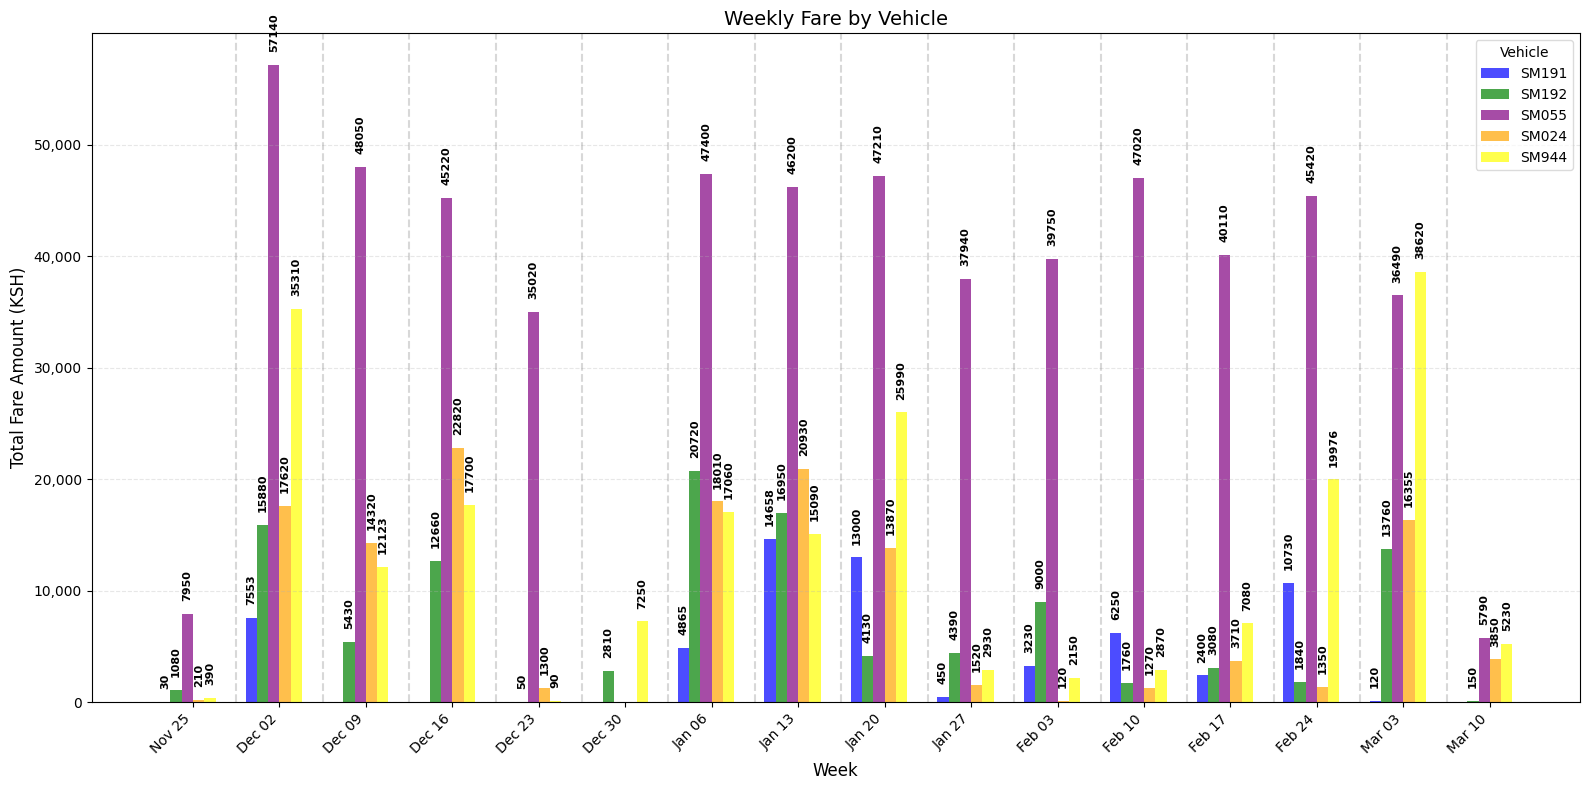

In [17]:

# Create a multi-vehicle weekly fare visualization (bar graph with grouped vehicles by week)
def plot_weekly_fares_grouped():
    # Aggregate total fare for each vehicle by week
    weekly_vehicle_fares = data.groupby(['week', 'vehicle_booked'])['amount'].sum().reset_index()
    
    # Filter out rows where vehicle_booked is NaN or not in our vehicles list
    weekly_vehicle_fares = weekly_vehicle_fares[
        weekly_vehicle_fares['vehicle_booked'].notna() & 
        weekly_vehicle_fares['vehicle_booked'].isin(vehicles)
    ]
    
    # Create a pivot table for better visualization
    pivot_data = weekly_vehicle_fares.pivot(index='vehicle_booked', columns='week', values='amount').fillna(0)
    
    # Ensure all vehicles are present
    for vehicle in vehicles:
        if vehicle not in pivot_data.index:
            pivot_data.loc[vehicle] = 0
    
    # Ensure all weeks are present
    for week in all_weeks:
        if week not in pivot_data.columns:
            pivot_data[week] = 0
    
    # Reorder columns chronologically
    pivot_data = pivot_data[all_weeks]
    
    # Plotting parameters
    fig, ax = plt.subplots(figsize=(16, 8))
    bar_width = 0.15  # Width of each bar
    week_spacing = 0.4  # Space between week segments
    
    # Initialize position for the first week
    current_position = 0
    tick_positions = []
    
    # Plot each week as a segment with bars side by side
    for i, week in enumerate(all_weeks):
        # Store the center position of this week segment for x-axis ticks
        week_center = current_position + (len(vehicles) * bar_width) / 2
        tick_positions.append(week_center)
        
        # Plot each vehicle's bar within this week segment
        for j, vehicle in enumerate(vehicles):
            # Calculate the specific position for this bar
            bar_position = current_position + j * bar_width
            
            # Get color for the vehicle
            color = vehicle_colors.get(vehicle, 'gray')
            
            # Get the value for this vehicle and week
            value = pivot_data.loc[vehicle, week] if vehicle in pivot_data.index else 0
            
            # Create the bar
            bar = ax.bar(
                bar_position, 
                value, 
                width=bar_width, 
                color=color, 
                label=vehicle if i == 0 else "", # Only add to legend once
                alpha=0.7
            )
            
            # Add value label if non-zero
            if value > 0:
                ax.text(
                    bar_position, 
                    value + max(pivot_data.values.max() * 0.02, 50), 
                    f"{int(value)}",
                    ha='center', 
                    va='bottom', 
                    fontsize=8, 
                    fontweight='bold',
                    rotation=90
                )
        
        # Move position for next week (including spacing)
        current_position += len(vehicles) * bar_width + week_spacing
    
    # Set custom x-ticks at the center of each week segment
    ax.set_xticks(tick_positions)
    
    # Format week labels to be more readable
    formatted_labels = []
    for week in all_weeks:
        # Convert week string to datetime for better formatting
        week_start = pd.Period(week).start_time
        week_end = pd.Period(week).end_time
        formatted_labels.append(f"{week_start.strftime('%b %d')}")
    
    ax.set_xticklabels(formatted_labels, rotation=45, ha='right')
    
    # Add vertical separators between week segments
    for i in range(1, len(all_weeks)):
        separator_position = i * (len(vehicles) * bar_width + week_spacing) - week_spacing/2
        ax.axvline(x=separator_position, color='gray', linestyle='--', alpha=0.3)
    
    # Labels and formatting
    ax.set_title("Weekly Fare by Vehicle", fontsize=14)
    ax.set_xlabel("Week", fontsize=12)
    ax.set_ylabel("Total Fare Amount (KSH)", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Create legend with colored patches
    legend = ax.legend(title="Vehicle", loc='upper right')
    legend.get_frame().set_alpha(0.7)
    
    # Set y-axis to start at 0
    ax.set_ylim(bottom=0)
    
    # Add comma formatting to y-axis for better readability
    from matplotlib.ticker import FuncFormatter
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Debug: Print pivot data to verify it contains values
    print("Pivot data:")
    # print(pivot_data)
    # plt.ylim(0, 100000)
    # Adjust layout for better spacing
    plt.tight_layout()

    plt.savefig("../files/weekly_total_earnings_trend_bar.png", dpi=300)
    
    # Show plot
    plt.show()
    
plot_weekly_fares_grouped()


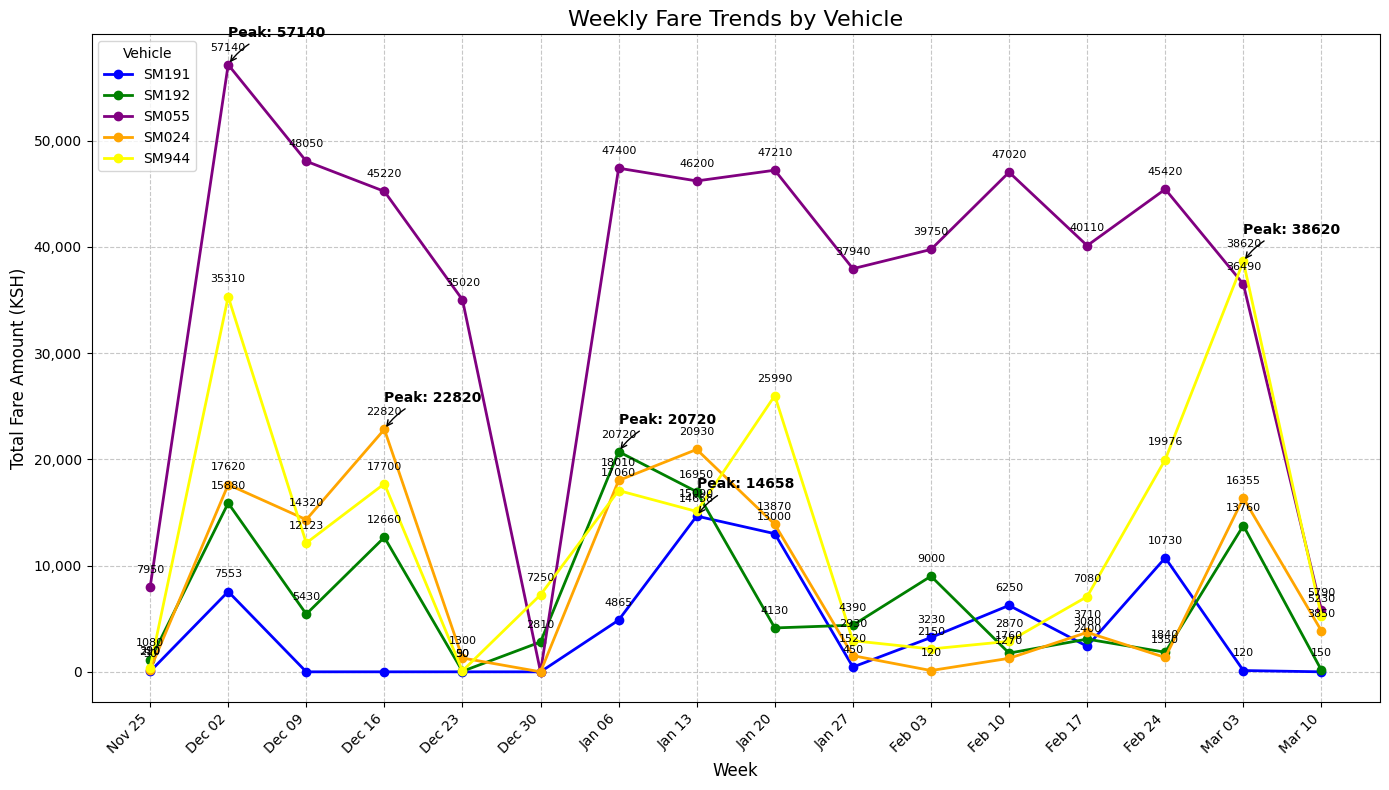

In [18]:

# Create a line graph for all vehicles' weekly incomes
def plot_weekly_fares_line():
    # Aggregate total fare for each vehicle by week
    weekly_vehicle_fares = data.groupby(['week', 'vehicle_booked'])['amount'].sum().reset_index()
    
    # Create a pivot table for better visualization
    pivot_data = weekly_vehicle_fares.pivot(index='week', columns='vehicle_booked', values='amount').fillna(0)
    
    # Ensure all vehicles are present
    for vehicle in vehicles:
        if vehicle not in pivot_data.columns:
            pivot_data[vehicle] = 0
    
    # Reindex with all weeks to ensure chronological order and fill missing weeks
    pivot_data = pivot_data.reindex(all_weeks).fillna(0)
    
    # Create line plot
    plt.figure(figsize=(14, 8))
    
    # Plot a line for each vehicle
    for vehicle in vehicles:
        if vehicle in pivot_data.columns:
            plt.plot(
                range(len(all_weeks)), 
                pivot_data[vehicle], 
                marker='o', 
                linewidth=2,
                color=vehicle_colors.get(vehicle, 'gray'),
                label=f"{vehicle}"
            )
    
    # Add data point markers with values
    for vehicle in vehicles:
        if vehicle in pivot_data.columns:
            for i, (week, value) in enumerate(zip(all_weeks, pivot_data[vehicle])):
                if value > 0:  # Only label non-zero values
                    plt.text(
                        i, value + max(pivot_data.max().max() * 0.02, 50), 
                        f"{int(value)}",
                        ha='center', 
                        va='bottom', 
                        fontsize=8
                    )
    
    # Format week labels to be more readable
    formatted_labels = []
    for week in all_weeks:
        # Convert week string to datetime for better formatting
        week_date = pd.Period(week).start_time
        formatted_labels.append(week_date.strftime('%b %d'))
    
    # Labels and formatting
    plt.title("Weekly Fare Trends by Vehicle", fontsize=16)
    plt.xlabel("Week", fontsize=12)
    plt.ylabel("Total Fare Amount (KSH)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(len(all_weeks)), formatted_labels, rotation=45, ha='right')
    
    # Add legend
    plt.legend(title="Vehicle", loc='upper left')
    
    # Add annotations for the peaks
    for vehicle in vehicles:
        if vehicle in pivot_data.columns:
            max_value = pivot_data[vehicle].max()
            if max_value > 0:
                max_week_idx = pivot_data[vehicle].idxmax()
                max_week_position = all_weeks.index(max_week_idx)
                plt.annotate(
                    f"Peak: {int(max_value)}",
                    xy=(max_week_position, max_value),
                    xytext=(0, 20),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
                    fontsize=10,
                    fontweight='bold'
                )
    
    # Format y-axis with commas
    from matplotlib.ticker import FuncFormatter
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Adjust layout for better spacing
    plt.tight_layout()

    plt.savefig("../files/weekly_total_earnings_trend_line.png", dpi=300)
    
    # Show plot
    plt.show()


plot_weekly_fares_line()


In [19]:
# Weekly totals for all vehicles combined
weekly_total = data.groupby('week')['amount'].sum().reset_index()
weekly_total = weekly_total.sort_values('week')

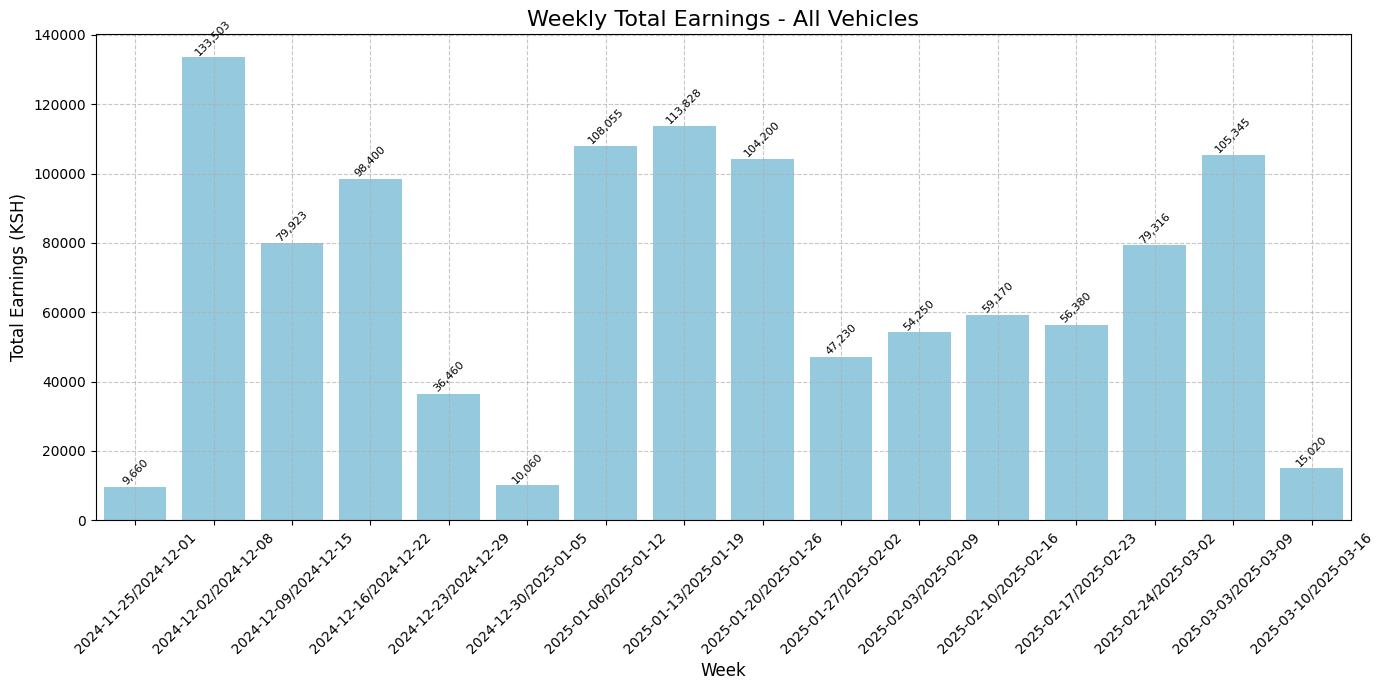

In [20]:
# VISUALIZATION 4: Weekly trends for all vehicles
plt.figure(figsize=(14, 7))
sns.barplot(x='week', y='amount', data=weekly_total, color='skyblue')

plt.title("Weekly Total Earnings - All Vehicles", fontsize=16)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Total Earnings (KSH)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Add value annotations
for i, row in weekly_total.iterrows():
    plt.text(i, row['amount'], f"{int(row['amount']):,}", ha='center', va='bottom', fontsize=8, rotation=45)

plt.tight_layout()
plt.savefig("../files/weekly_total_earnings_bar.png", dpi=300)
plt.show()

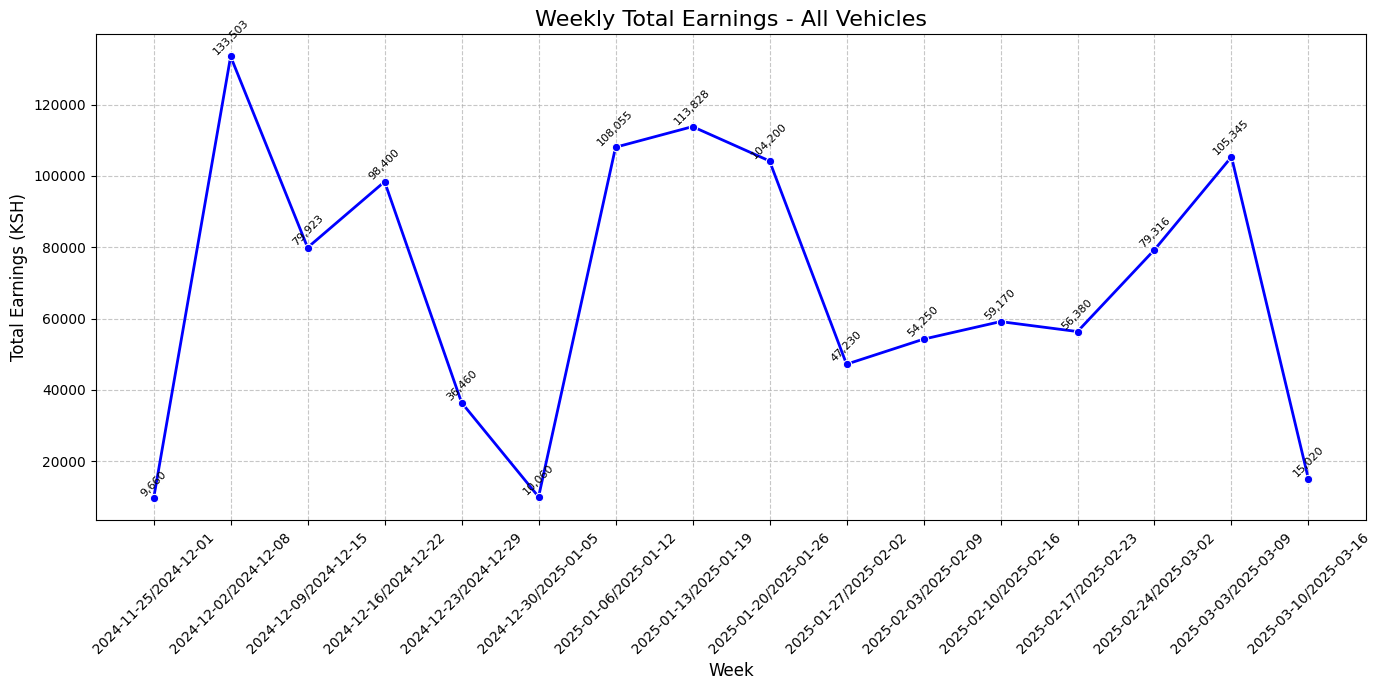

In [21]:
# VISUALIZATION 3: Weekly trends for all vehicles
plt.figure(figsize=(14, 7))
sns.lineplot(x='week', y='amount', data=weekly_total, marker='o', color='blue', linewidth=2)

plt.title("Weekly Total Earnings - All Vehicles", fontsize=16)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Total Earnings (KSH)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Add value annotations
for i, row in weekly_total.iterrows():
    plt.text(i, row['amount'], f"{int(row['amount']):,}", ha='center', va='bottom', fontsize=8, rotation=45)

plt.tight_layout()
plt.savefig("../files/weekly_total_earnings_line.png", dpi=300)
plt.show()

<Figure size 1600x800 with 0 Axes>

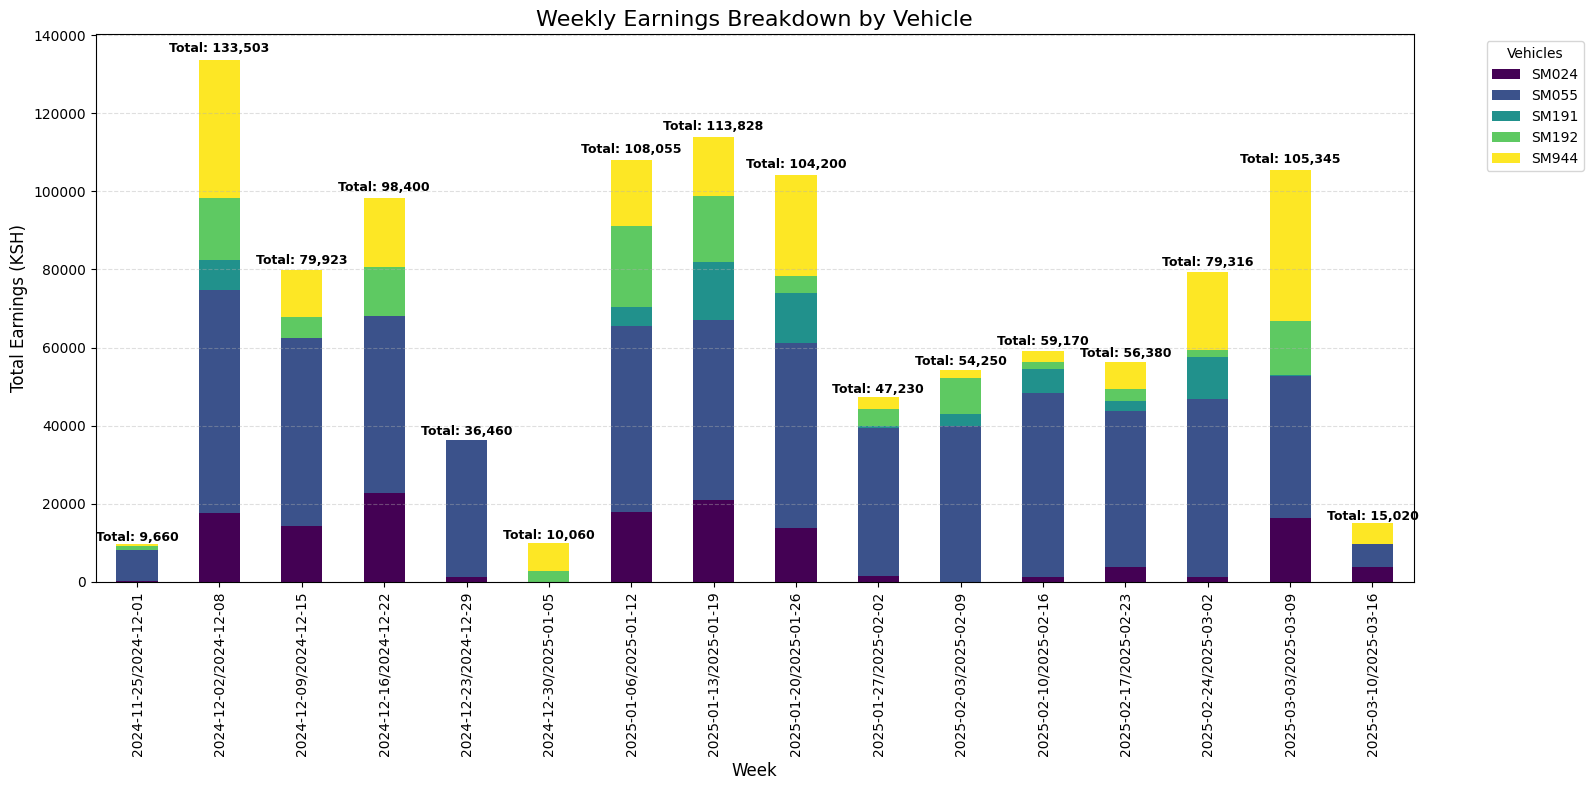

In [22]:
# VISUALIZATION 6: Combined view showing weekly breakdown by vehicle and total
plt.figure(figsize=(16, 8))

# Create a stacked bar chart
weekly_by_vehicle_pivot = weekly_by_vehicle.pivot_table(index='week', columns='vehicle_booked', values='amount')
weekly_by_vehicle_pivot = weekly_by_vehicle_pivot.fillna(0)  # Replace NaN with 0
weekly_by_vehicle_pivot = weekly_by_vehicle_pivot.sort_index()  # Sort by month

weekly_by_vehicle_pivot.plot(kind='bar', stacked=True, figsize=(16, 8), colormap='viridis')

plt.title("Weekly Earnings Breakdown by Vehicle", fontsize=16)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Total Earnings (KSH)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title="Vehicles", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add total value annotations
weekly_totals = weekly_by_vehicle_pivot.sum(axis=1)
for i, total in enumerate(weekly_totals):
    plt.text(i, total + (total*0.01), f"Total: {int(total):,}", ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()

plt.savefig("../files/weekly_stacked_earnings.png", dpi=300)

plt.show()